In [1]:
from functools import partial
from pathlib import Path
from typing import Tuple, Union
from itertools import chain
from models import ConvNet
from pandas import DataFrame
import math
import random
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import Generator

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim import SGD

from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor

from lightly.transforms import SimCLRTransform
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss
from lightly.data import LightlyDataset

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss


/Users/sophiastiles/.pyenv/versions/3.11.11/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [2]:
device = "cpu"
dataset_class = partial(MNIST, root=Path("mnist_data"), download=True)

train_transform = SimCLRTransform(
    input_size=28,
    min_scale=0.5,
    hf_prob=0,
    rr_prob=0,
    vf_prob=0,
    normalize=dict(mean=[0.1307], std=[0.3081]),
)

test_transform = Compose([ToTensor(), Normalize(mean=[0.1307], std=[0.3081])])

train_set_for_training = LightlyDataset.from_torch_dataset(dataset_class(train=True), transform=train_transform)
train_loader_for_training = DataLoader(train_set_for_training, batch_size=1_024, shuffle=True, drop_last=True)

# Step 3: Define the encoder (ConvNet)
encoder = ConvNet(input_shape=[28, 28], output_size=128)
encoder = encoder.to(device)

# Step 4: Define the projection head (SimCLRProjectionHead)
proj_head = SimCLRProjectionHead(input_dim=128, hidden_dim=512)
proj_head = proj_head.to(device)

# Step 5: Define the loss function (NTXentLoss)
loss_fn = NTXentLoss()

# Step 6: Set up the optimizer
params = chain(encoder.parameters(), proj_head.parameters())
optimizer = SGD(params, lr=1, weight_decay=1e-4)


/Users/sophiastiles/.pyenv/versions/3.11.11/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [3]:
def get_next(dataloader: DataLoader) -> Union[Tensor, Tuple]:
    try:
        return next(dataloader)
    except:
        dataloader = iter(dataloader)
        return next(dataloader)

def save_table(path: Union[Path, str], table: DataFrame, formatting: dict) -> None:
    for key in formatting:
        if key in table:
            table[key] = table[key].apply(formatting[key])

    table.to_csv(path, index=False)

### Train the Model

In [4]:
import pandas as pd

steps, losses = [], []
n_optim_steps = 10

for step in range(n_optim_steps):
    (inputs_0, inputs_1), _, _ = get_next(train_loader_for_training)

    embeddings_0 = proj_head(encoder(inputs_0.to(device)))
    embeddings_1 = proj_head(encoder(inputs_1.to(device)))

    loss = loss_fn(embeddings_0, embeddings_1)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    steps += [step]
    losses += [loss.item()]
    print(f"Step {step}: loss = {loss}")

Step 0: loss = 7.482248306274414
Step 1: loss = 7.605940341949463
Step 2: loss = 7.674834251403809
Step 3: loss = 7.77217435836792
Step 4: loss = 7.623018741607666
Step 5: loss = 7.376786708831787
Step 6: loss = 7.392028331756592
Step 7: loss = 7.34305477142334
Step 8: loss = 6.99934720993042
Step 9: loss = 7.099389553070068


In [5]:
# print("Saving results...")
# train_log = pd.DataFrame({"step": steps, "loss": losses})
# formatting = {"loss": "{:.4f}".format}
# save_table("train_encoders/pretraining.csv", train_log, formatting)

# torch.save(encoder.state_dict(), "train_encoders/encoder.pth")
# torch.save(proj_head.state_dict(), "train_encoders/projection_head.pth")

### Compute Embeddings

In [8]:
@torch.inference_mode()
def encode(loader: DataLoader, encoder: ConvNet, device: str) -> np.ndarray:
    embeddings = []

    for idx, (images_i, _) in enumerate(loader):
        if idx % 10 == 0:
            print(f"encoding step {idx}")
        images_i = images_i.to(device)
        embeddings_i = encoder(images_i)
        embeddings += [embeddings_i.cpu().numpy()]
    return np.concatenate(embeddings)

max_array_size = int(2e7)
# GitHub has a max file size of 100MB, which translates to 2.5e7 32-bit floats.
embeddings_simclr_train, embeddings_simclr_test = None, None
labels_train, labels_test = None, None
for subset in ("train", "test"):
    print(f"\n********** On subset {subset}")
    
    # Create dataset and DataLoader for current subset
    dataset = dataset_class(train=(subset == "train"), transform=test_transform)
    loader = DataLoader(dataset, batch_size=1_024)

    # Generate embeddings for the subset
    embeddings = encode(loader, encoder, device)
    if subset == "train":
        embeddings_simclr_train = embeddings
    else:
        embeddings_simclr_test = embeddings

    # Check if the embeddings size exceeds the max allowed size
    if embeddings.size > max_array_size:
        # Split the embeddings into smaller parts
        n_splits = math.ceil(embeddings.size / max_array_size)

        for i, embeddings_i in enumerate(np.array_split(embeddings, n_splits, axis=0)):
            # Save each part to a separate file
            filepath = f"embeddings/simclr_{subset}_part{i + 1}of{n_splits}.npy"
            # np.save(filepath, embeddings_i, allow_pickle=False)
    # else:
        # Save the full embeddings if it's under the max size
        # np.save(f"embeddings/simclr_{subset}.npy", embeddings, allow_pickle=False)

    # Save the labels
    if subset == "train":
        labels_train = dataset.targets
    else:
        labels_test = dataset.targets
    # np.save(f"embeddings/labels_{subset}.npy", dataset.targets, allow_pickle=False)


********** On subset train
encoding step 0
encoding step 10
encoding step 20
encoding step 30
encoding step 40
encoding step 50

********** On subset test
encoding step 0


### Evalute Embeddings

In [9]:
def get_rng(seed: int = -1) -> Generator:
    """
    References:
        https://pytorch.org/docs/stable/notes/randomness.html
    """
    if seed == -1:
        seed = random.randint(0, int(1e6))

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    return np.random.default_rng(seed)


def compute_mean_and_std(
    x: np.ndarray, axis: int = 0, keepdims: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    To avoid dividing by zero we set the standard deviation to one if it is less than epsilon.
    """
    mean = np.mean(x, axis=axis, keepdims=keepdims)
    std = np.std(x, axis=axis, keepdims=keepdims)

    eps = np.finfo(x.dtype).eps
    if isinstance(std, np.ndarray):
        std[std < eps] = 1
    elif std < eps:
        std = 1
    return mean, std

def sample_n_per_class(labels: np.ndarray, n_per_class: int, rng: Generator) -> np.ndarray:
    sampled_inds = []

    for _class in np.unique(labels):
        class_inds = np.flatnonzero(labels == _class)
        sampled_inds += [rng.choice(class_inds, size=n_per_class, replace=False)]

    sampled_inds = np.concatenate(sampled_inds)
    sampled_inds = rng.permutation(sampled_inds)

    return sampled_inds

In [11]:
seed = 0    # TODO: change default seed 
rng = get_rng(seed)

mean, std = compute_mean_and_std(embeddings_simclr_test)
train_inputs = (embeddings_simclr_train - mean) / std
test_inputs = (embeddings_simclr_test - mean) / std

n_per_class, n_labels_end = 1, 500
n_labels, accs, logliks = [], [], []

while True:
    train_inds = sample_n_per_class(labels_train, n_per_class, rng)
    model = LogisticRegression(C=1, max_iter=1_000)
    model.fit(train_inputs[train_inds], labels_train[train_inds])

    probs = model.predict_proba(test_inputs)
    acc = model.score(test_inputs, labels_test)
    loglik = -log_loss(labels_test, probs)

    n_labels += [len(train_inds)]
    accs += [acc]
    logliks += [loglik]

    if len(train_inds) >= n_labels_end:
        break
    else:
        n_per_class += 1

test_log = pd.DataFrame({"n_labels": n_labels, "test_acc": accs, "test_loglik": logliks})
formatting = {
    "n_labels": "{:03}".format,
    "test_acc": "{:.4f}".format,
    "test_loglik": "{:.4f}".format,
}
# save_table(f"results/testing_seed{seed}.csv", test_log, formatting)

### Plot Results

In [12]:
def plot_results(save_path: str) -> None:
    plt.figure(figsize=(12, 6))

    # Plot Test Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(n_labels, [acc * 100 for acc in accs])
    plt.xlabel("Number of Labels")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Accuracy")
    plt.grid(True)

    # Plot Test Log Likelihood
    plt.subplot(1, 2, 2)
    plt.plot(n_labels, logliks)
    plt.xlabel("Number of Labels")
    plt.ylabel("Test Expected Log Likelihood")
    plt.title("Expected Log Likelihood")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

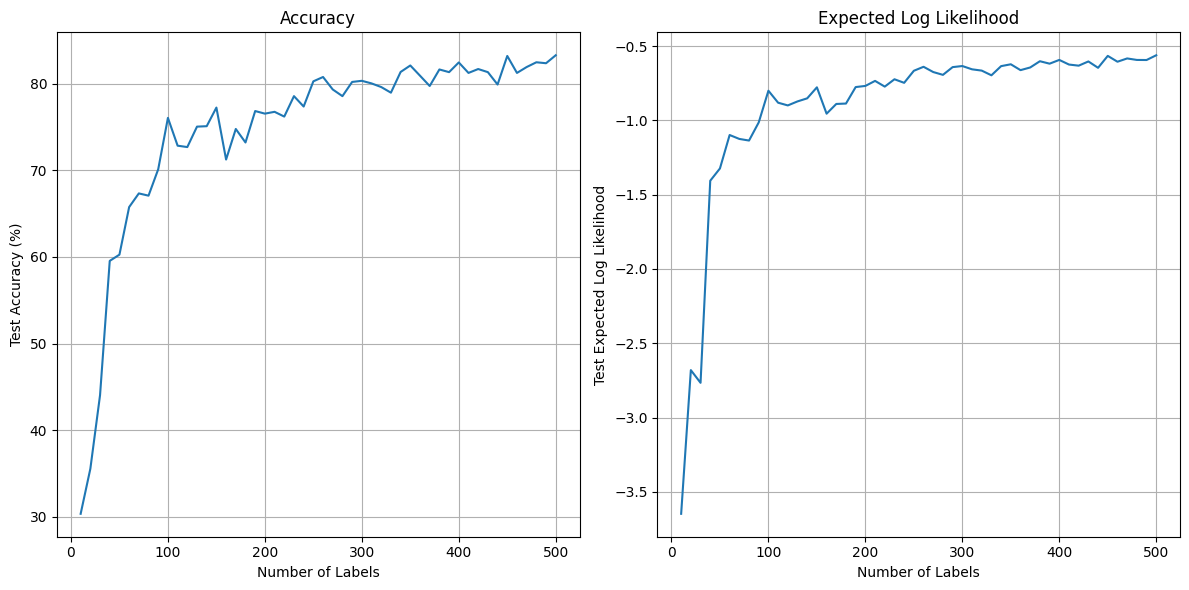

In [13]:
plot_results("plots/10_epochs__10k_iters.png")